## Forecasting Test Inspired by Siami-Namini et al. (2018)

This notebook contains a forecasting test inspired by the study A Comparison of ARIMA and LSTM in Forecasting Time Series by Siami-Namini et al. The test expands on their work by including GRU (Gated Recurrent Unit) alongside ARIMA and LSTM models.

Both **weekly** and **monthly** time series data are used to evaluate and compare model performance based on predictive accuracy.


# Weekly

In [ ]:
!pip install yfinance pmdarima

### Data import + Assumption tests



In [ ]:
import yfinance as yf
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, q_stat
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, jarque_bera
import warnings
warnings.filterwarnings("ignore")

# --- Load Data ---
tickers = ['AAPL', 'JNJ', 'JPM', 'BA', '^DJI']
start_date = '2015-01-01'
end_date = '2025-01-01'

def load_data(ticker):
    df = yf.download(ticker, start=start_date, end=end_date, interval='1wk')
    returns = np.log(df['Close']).diff().dropna()
    return returns

data = {ticker: load_data(ticker) for ticker in tickers}

# --- Diagnostic Tests ---
for ticker, series in data.items():
    print(f"\n📈 {ticker}")

    # Linearity check
    X = sm.add_constant(series.shift(1).dropna())
    y = series[1:]
    model = sm.OLS(y, X).fit()
    residuals = model.resid

    # Stationarity (ADF test)
    adf_pvalue = adfuller(series)[1]

    # White noise (Ljung-Box on residuals)
    lb_pvalue = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].iloc[0]

    # Normality
    shapiro_p = shapiro(residuals)[1]
    jb_p = jarque_bera(residuals)[1]

    print(f" - ADF (Stationarity) p-value: {adf_pvalue:.4f} → {'Stationary' if adf_pvalue < 0.05 else 'Non-stationary'}")
    print(f" - Ljung-Box (White Noise) p-value: {lb_pvalue:.4f} → {'White noise' if lb_pvalue > 0.05 else 'Not white noise'}")
    print(f" - Shapiro-Wilk Normality p-value: {shapiro_p:.4f} → {'Normal' if shapiro_p > 0.05 else 'Not normal'}")
    print(f" - Jarque-Bera Normality p-value: {jb_p:.4f} → {'Normal' if jb_p > 0.05 else 'Not normal'}")




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



📈 AAPL
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.8661 → White noise
 - Shapiro-Wilk Normality p-value: 0.0000 → Not normal
 - Jarque-Bera Normality p-value: 0.0000 → Not normal

📈 JNJ
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.8118 → White noise
 - Shapiro-Wilk Normality p-value: 0.0000 → Not normal
 - Jarque-Bera Normality p-value: 0.0000 → Not normal

📈 JPM
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.5905 → White noise
 - Shapiro-Wilk Normality p-value: 0.0000 → Not normal
 - Jarque-Bera Normality p-value: 0.0000 → Not normal

📈 BA
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.0770 → White noise
 - Shapiro-Wilk Normality p-value: 0.0000 → Not normal
 - Jarque-Bera Normality p-value: 0.0000 → Not normal

📈 ^DJI
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.0651 → 

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=30, title=""):
    # Differencing if needed
    diff_series = series.diff().dropna()

    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f'ACF & PACF for {title}', fontsize=16)

    # Plot ACF
    plot_acf(diff_series, ax=axes[0], lags=lags)
    axes[0].set_title("ACF (for MA order)")

    # Plot PACF
    plot_pacf(diff_series, ax=axes[1], lags=lags, method="ywm")
    axes[1].set_title("PACF (for AR order)")

    plt.tight_layout()
    plt.show()


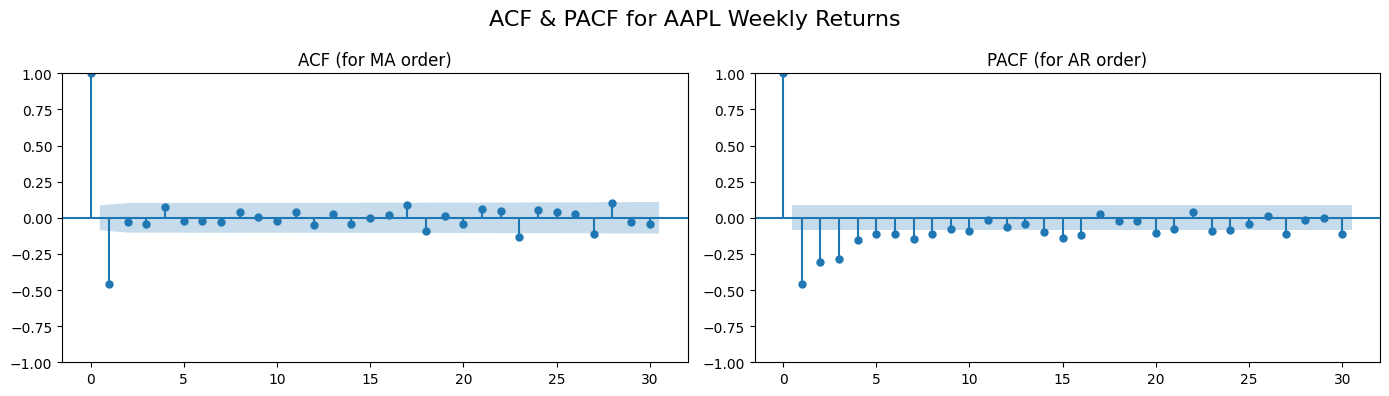

In [ ]:
plot_acf_pacf(data['AAPL'], lags=30, title="AAPL Weekly Returns")


Although the ARIMA model should ideally be tuned individually for each time series using model selection criteria this test follows the approach used by Siami-Namini et al. (2018)


In [ ]:
# ARIMA Forecast Function
def forecast_arima(series):
    series = pd.Series(series).dropna().astype('float64')
    train_size = int(len(series) * 0.7)
    train, test = series[:train_size], series[train_size:]

    predictions = []
    history = list(train)

    for t in range(len(test)):
        model = ARIMA(history, order=(5, 1, 0))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t])

    rmse = sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    return rmse, mae, mse


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
import numpy as np

def forecast_lstm(series):
    # Reshape and scale
    series = series.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(series)

    def create_dataset(dataset, look_back=20):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:i + look_back, 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 20
    train_size = int(len(data_scaled) * 0.8)
    train, test = data_scaled[:train_size], data_scaled[train_size:]

    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], look_back, 1))
    X_test = X_test.reshape((X_test.shape[0], look_back, 1))

    # LSTM Model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    # Early stopping to avoid overfitting
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Training
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    # Prediction and evaluation
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = sqrt(mean_squared_error(y_test_orig, y_pred))
    mae = mean_absolute_error(y_test_orig, y_pred)
    mse = mean_squared_error(y_test_orig, y_pred)

    return rmse, mae, mse




In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
import numpy as np

def forecast_gru(series):
    #  Preprocess the series
    series = series.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(series)

    def create_dataset(dataset, look_back=20):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    # Split and prepare data
    look_back = 20
    train_size = int(len(data_scaled) * 0.8)
    train, test = data_scaled[:train_size], data_scaled[train_size:]

    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    X_train = X_train.reshape((X_train.shape[0], look_back, 1))
    X_test = X_test.reshape((X_test.shape[0], look_back, 1))

    # GRU model
    model = Sequential()
    model.add(GRU(units=64, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    # 4. Train with early stopping
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    # 5. Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = sqrt(mean_squared_error(y_test_orig, y_pred))
    mae = mean_absolute_error(y_test_orig, y_pred)
    mse = mean_squared_error(y_test_orig, y_pred)

    return rmse, mae, mse



In [ ]:
warnings.filterwarnings("ignore")

# Comparison and Print RMSE with Percentage Reductions
results = []

for ticker in tickers:
    print(f"\n✅ {ticker}:")

    try:
        series = data[ticker].squeeze()

        rmse_arima, _, _ = forecast_arima(series)
        rmse_lstm, _, _ = forecast_lstm(series)
        rmse_gru, _, _ = forecast_gru(series)

        # Calculate % reduction
        red_lstm = 100 * (rmse_arima - rmse_lstm) / rmse_arima
        red_gru = 100 * (rmse_arima - rmse_gru) / rmse_arima

        # Save results if needed
        results.append((ticker, rmse_arima, rmse_lstm, red_lstm, rmse_gru, red_gru))

        # Print example
        print(f"ARIMA → RMSE={rmse_arima:.6f}")
        print(f"LSTM  → RMSE={rmse_lstm:.6f}, Reduction vs ARIMA = {red_lstm:.2f}%")
        print(f"GRU   → RMSE={rmse_gru:.6f}, Reduction vs ARIMA = {red_gru:.2f}%")

    except Exception as e:
        print(f"❌ Error with {ticker}: {e}")





✅ AAPL:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
ARIMA → RMSE=0.040814
LSTM  → RMSE=0.031198, Reduction vs ARIMA = 23.56%
GRU   → RMSE=0.031034, Reduction vs ARIMA = 23.96%

✅ JNJ:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
ARIMA → RMSE=0.023166
LSTM  → RMSE=0.022407, Reduction vs ARIMA = 3.28%
GRU   → RMSE=0.022607, Reduction vs ARIMA = 2.41%

✅ JPM:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
ARIMA → RMSE=0.039609
LSTM  → RMSE=0.029820, Reduction vs ARIMA = 24.71%
GRU   → RMSE=0.030582, Reduction vs ARIMA = 22.79%

✅ BA:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
ARIMA → RMSE=0.054879
LSTM  → RMSE=0.053274, Reduction vs ARIMA = 2.92%
GRU   → RMSE=0.047575, Reduction vs ARIMA = 13.31%

✅ ^DJI:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
ARIMA → RMSE=0.024059
LSTM  → RMSE=0.017748, Reduction vs ARIMA = 26.23%
GRU

# Monthly

In [ ]:
import yfinance as yf
import statsmodels.api as sm
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro, jarque_bera
import warnings
warnings.filterwarnings("ignore")

# --- Load Monthly Data ---
tickers = ['AAPL', 'JNJ', 'JPM', 'BA', '^DJI']
start_date = '2015-01-01'
end_date = '2025-01-01'

def load_data(ticker):
    df = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
    returns = np.log(df['Close']).diff().dropna()
    return returns

data = {ticker: load_data(ticker) for ticker in tickers}

# --- Diagnostic Tests ---
for ticker, series in data.items():
    print(f"\n📈 {ticker}")

    # Linearity check
    X = sm.add_constant(series.shift(1).dropna())
    y = series[1:]
    model = sm.OLS(y, X).fit()
    residuals = model.resid

    # Stationarity (ADF test)
    adf_pvalue = adfuller(series)[1]

    # White noise (Ljung-Box on residuals)
    lb_pvalue = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].iloc[0]

    # Normality
    shapiro_p = shapiro(residuals)[1]
    jb_p = jarque_bera(residuals)[1]

    # Print results
    print(f" - ADF (Stationarity) p-value: {adf_pvalue:.4f} → {'Stationary' if adf_pvalue < 0.05 else 'Non-stationary'}")
    print(f" - Ljung-Box (White Noise) p-value: {lb_pvalue:.4f} → {'White noise' if lb_pvalue > 0.05 else 'Not white noise'}")
    print(f" - Shapiro-Wilk Normality p-value: {shapiro_p:.4f} → {'Normal' if shapiro_p > 0.05 else 'Not normal'}")
    print(f" - Jarque-Bera Normality p-value: {jb_p:.4f} → {'Normal' if jb_p > 0.05 else 'Not normal'}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📈 AAPL
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.7277 → White noise
 - Shapiro-Wilk Normality p-value: 0.8023 → Normal
 - Jarque-Bera Normality p-value: 0.5671 → Normal

📈 JNJ
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.0099 → Not white noise
 - Shapiro-Wilk Normality p-value: 0.8533 → Normal
 - Jarque-Bera Normality p-value: 0.9786 → Normal

📈 JPM
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.3397 → White noise
 - Shapiro-Wilk Normality p-value: 0.1856 → Normal
 - Jarque-Bera Normality p-value: 0.0770 → Normal

📈 BA
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.2438 → White noise
 - Shapiro-Wilk Normality p-value: 0.0005 → Not normal
 - Jarque-Bera Normality p-value: 0.0000 → Not normal

📈 ^DJI
 - ADF (Stationarity) p-value: 0.0000 → Stationary
 - Ljung-Box (White Noise) p-value: 0.4311 → White noise
 - Shapi

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=30, title=""):
    # Differencing if needed
    diff_series = series.diff().dropna()

    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f'ACF & PACF for {title}', fontsize=16)

    # Plot ACF
    plot_acf(diff_series, ax=axes[0], lags=lags)
    axes[0].set_title("ACF (for MA order)")

    # Plot PACF
    plot_pacf(diff_series, ax=axes[1], lags=lags, method="ywm")
    axes[1].set_title("PACF (for AR order)")

    plt.tight_layout()
    plt.show()

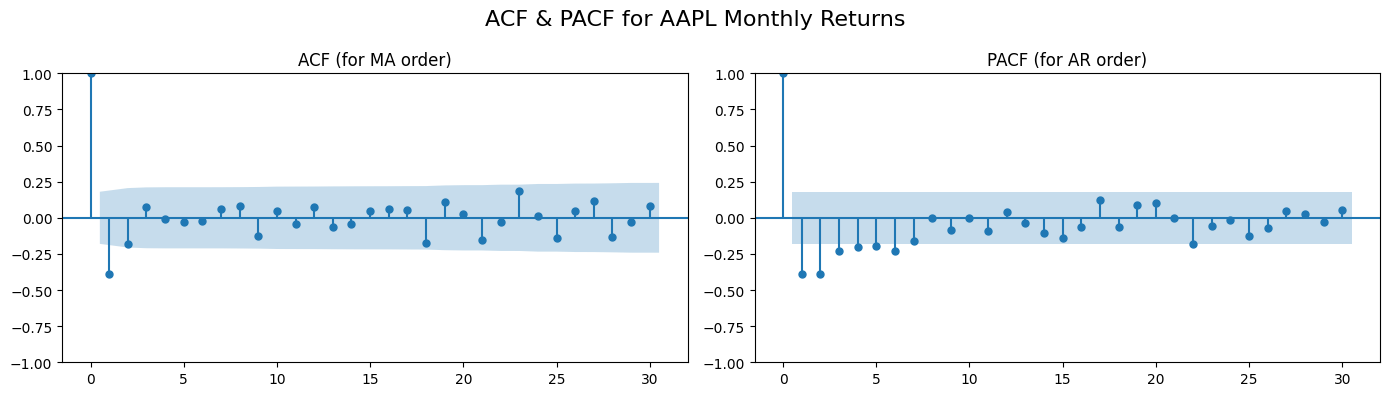

In [ ]:
    plot_acf_pacf(data['AAPL'], lags=30, title="AAPL Monthly Returns")


In [ ]:
# ARIMA Forecast Function
def forecast_arima(series):
    series = pd.Series(series).dropna().astype('float64')
    train_size = int(len(series) * 0.7)
    train, test = series[:train_size], series[train_size:]

    predictions = []
    history = list(train)

    for t in range(len(test)):
        model = ARIMA(history, order=(5, 1, 0))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test.iloc[t])

    rmse = sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    return rmse, mae, mse

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
import numpy as np

def forecast_lstm(series):
    # Reshape and scale
    series = series.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(series)

    def create_dataset(dataset, look_back=20):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:i + look_back, 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 20
    train_size = int(len(data_scaled) * 0.8)
    train, test = data_scaled[:train_size], data_scaled[train_size:]

    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], look_back, 1))
    X_test = X_test.reshape((X_test.shape[0], look_back, 1))

    # Model architecture
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    # Early stopping to avoid overfitting
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Training
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    # Prediction and evaluation
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = sqrt(mean_squared_error(y_test_orig, y_pred))
    mae = mean_absolute_error(y_test_orig, y_pred)
    mse = mean_squared_error(y_test_orig, y_pred)

    return rmse, mae, mse




In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
import numpy as np

def forecast_gru(series):
    # Preprocess the series
    series = series.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(series)

    def create_dataset(dataset, look_back=20):
        X, Y = [], []
        for i in range(len(dataset) - look_back):
            X.append(dataset[i:(i + look_back), 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    # Split and prepare data
    look_back = 20
    train_size = int(len(data_scaled) * 0.8)
    train, test = data_scaled[:train_size], data_scaled[train_size:]

    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    X_train = X_train.reshape((X_train.shape[0], look_back, 1))
    X_test = X_test.reshape((X_test.shape[0], look_back, 1))

    # Build GRU model
    model = Sequential()
    model.add(GRU(units=64, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(GRU(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train with early stopping
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = sqrt(mean_squared_error(y_test_orig, y_pred))
    mae = mean_absolute_error(y_test_orig, y_pred)
    mse = mean_squared_error(y_test_orig, y_pred)

    return rmse, mae, mse


In [ ]:
# Run Comparison and Print RMSE with Percentage Reductions
results = []

for ticker in tickers:
    print(f"\n✅ {ticker}:")

    try:
        series = data[ticker].squeeze()

        rmse_arima, _, _ = forecast_arima(series)
        rmse_lstm, _, _ = forecast_lstm(series)
        rmse_gru, _, _ = forecast_gru(series)

        # Calculate % reduction
        red_lstm = 100 * (rmse_arima - rmse_lstm) / rmse_arima
        red_gru = 100 * (rmse_arima - rmse_gru) / rmse_arima

        # Save results if needed
        results.append((ticker, rmse_arima, rmse_lstm, red_lstm, rmse_gru, red_gru))

        # Print like example
        print(f"ARIMA → RMSE={rmse_arima:.6f}")
        print(f"LSTM  → RMSE={rmse_lstm:.6f}, Reduction vs ARIMA = {red_lstm:.2f}%")
        print(f"GRU   → RMSE={rmse_gru:.6f}, Reduction vs ARIMA = {red_gru:.2f}%")

    except Exception as e:
        print(f"❌ Error with {ticker}: {e}")




✅ AAPL:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
ARIMA → RMSE=0.086122
LSTM  → RMSE=0.034571, Reduction vs ARIMA = 59.86%
GRU   → RMSE=0.039259, Reduction vs ARIMA = 54.41%

✅ JNJ:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
ARIMA → RMSE=0.053836
LSTM  → RMSE=0.048776, Reduction vs ARIMA = 9.40%
GRU   → RMSE=0.031957, Reduction vs ARIMA = 40.64%

✅ JPM:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
ARIMA → RMSE=0.082389
LSTM  → RMSE=0.079125, Reduction vs ARIMA = 3.96%
GRU   → RMSE=0.099453, Reduction vs ARIMA = -20.71%

✅ BA:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
ARIMA → RMSE=0.122724
LSTM  → RMSE=0.101791, Reduction vs ARIMA = 17.06%
GRU   → RMSE=0.103416, Reduction vs ARIMA = 15.73%

✅ ^DJI:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
ARIMA → RMSE=0.052229
LSTM  → RMSE=0.047770, Reduction vs ARIMA = 8.54%
GR

While it is generally shown in the literature and the tests here, that LSTM and GRU models outperform traditional ARIMA models in time series forecasting, a more in-depth analysis would require selecting the optimal ARIMA parameters for each series individually. In this test, a fixed ARIMA(5,1,0) model is used for simplicity and to maintain consistency with the approach by Siami-Namini et al. (2018).
